### Importing Libraries
- **TensorFlow and Keras**: For building and training deep learning models.
- **Matplotlib**: For visualizing data and model performance.


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Defining Hyperparameters
- **IMAGE_SIZE**: Dimensions of the input image (256x256).
- **BATCH_SIZE**: Number of samples per training batch (32).
- **CHANNELS**: Number of color channels (3 for RGB).
- **EPOCHS**: Total training iterations (10).


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10

### Loading the Dataset
- **Source**: Loads images from the `PlantVillage` directory.
- **Shuffle**: Randomly shuffles the dataset.
- **Image Size**: Resizes images to 256x256 pixels.
- **Batch Size**: Groups images into batches of 32.


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

### Displaying a Sample Batch
- **Operation**: Fetches one batch of images and their corresponding labels from the dataset.
- **Image Shape**: Prints the shape of the image batch.
- **Label Values**: Converts and prints the label batch to a NumPy array.


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 2 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0]


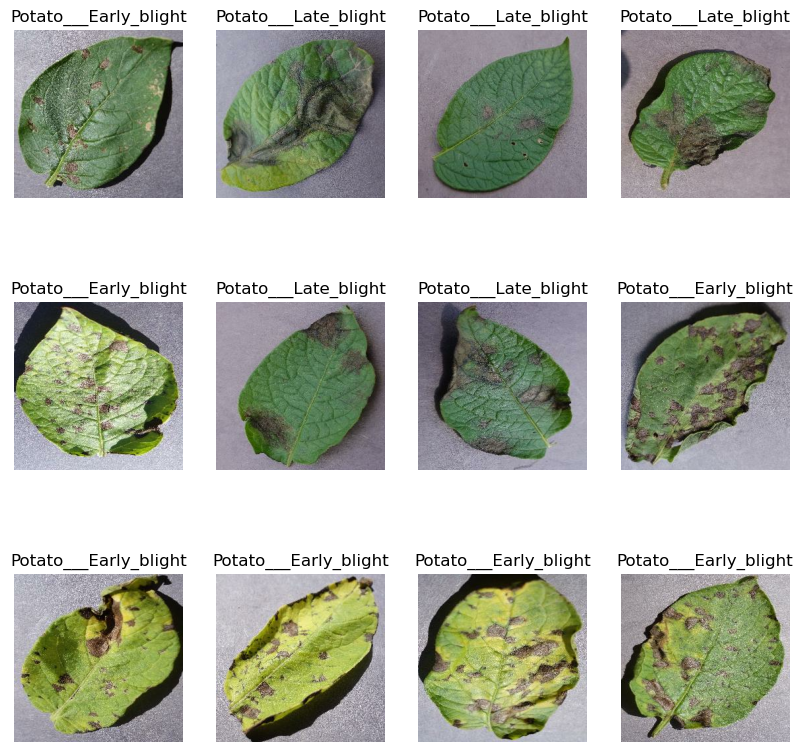

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
   for i in range(12):
      ax = plt.subplot(3, 4, i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

In [9]:
train_size = 0.8
len(dataset) * train_size


54.400000000000006

In [10]:
train_Ds = dataset.take(54)
len(train_Ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

### Splitting the Dataset
- **Function**: `get_dataset_partitions_tf` splits the dataset into training, validation, and test sets.
- **Parameters**:
  - `train_split`, `val_split`, `test_split`: Specifies the proportion of each split (default 80%, 10%, 10%).
  - `shuffle`: Option to shuffle the dataset before splitting (default `True`).
  - `shuffle_size`: Defines the shuffle buffer size (default 10,000).
- **Operation**: The dataset is shuffled, then partitioned based on the specified splits and returned as separate `train_ds`, `val_ds`, and `test_ds`.


In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

### Optimizing Dataset Performance
- **Operation**: Caches, shuffles, and prefetches the dataset to improve training efficiency.
- **Cache**: Caches the dataset in memory for faster access.
- **Shuffle**: Randomly shuffles the dataset with a buffer size of 1000.
- **Prefetch**: Prefetches data to overlap the data loading with model training, using `AUTOTUNE` to automatically adjust the buffer size for optimal performance.


In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [21]:
from tensorflow.keras import layers, Sequential
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

In [22]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

### Defining the CNN Model
- **Model Type**: A Sequential Convolutional Neural Network (CNN) with multiple Conv2D and MaxPooling2D layers.
- **Input Shape**: The model accepts inputs of shape `(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)`.
- **Convolutional Layers**: Uses multiple `Conv2D` layers with ReLU activation to extract features from the images.
- **MaxPooling**: Applies `MaxPooling2D` after each convolutional layer to reduce spatial dimensions.
- **Fully Connected Layers**: After flattening the features, a `Dense` layer with 64 units (ReLU activation) is followed by an output layer with `n_classes` units and a softmax activation function.
- **Building the Model**: The model is built with the specified input shape.


In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape = input_shape)

c:\Users\DELL LAPTOP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.4684 - loss: 0.9481 - val_accuracy: 0.5729 - val_loss: 0.8068
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5819 - loss: 0.7865 - val_accuracy: 0.7969 - val_loss: 0.4896
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7803 - loss: 0.4680 - val_accuracy: 0.9062 - val_loss: 0.3026
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8627 - loss: 0.3453 - val_accuracy: 0.9323 - val_loss: 0.1976
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.8977 - loss: 0.2509 - val_accuracy: 0.9375 - val_loss: 0.1254
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9084 - loss: 0.2478 - val_accuracy: 0.8906 - val_loss: 0.2756
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.9285 - loss: 0.1859 - val_accuracy: 0.9531 - val_loss: 0.1308
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9422 - loss: 0.1626 - val_accuracy: 0.9583 - v

In [28]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.8586 - loss: 0.3378


In [29]:
scores

[0.2972272038459778, 0.87890625]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

10

In [35]:
history.history['loss'][:5]

[0.896668016910553,
 0.6992928385734558,
 0.46297577023506165,
 0.3251377046108246,
 0.2429969161748886]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

### Visualizing Training and Validation Metrics
- **Operation**: Plots the training and validation accuracy and loss over the epochs.
- **Left Plot**: Displays the training and validation accuracy.
- **Right Plot**: Displays the training and validation loss.
- **Details**: 
  - `acc` and `val_acc` represent training and validation accuracy, respectively.
  - `loss` and `val_loss` represent training and validation loss, respectively.
  - Legends are positioned at the lower right (accuracy) and upper right (loss).


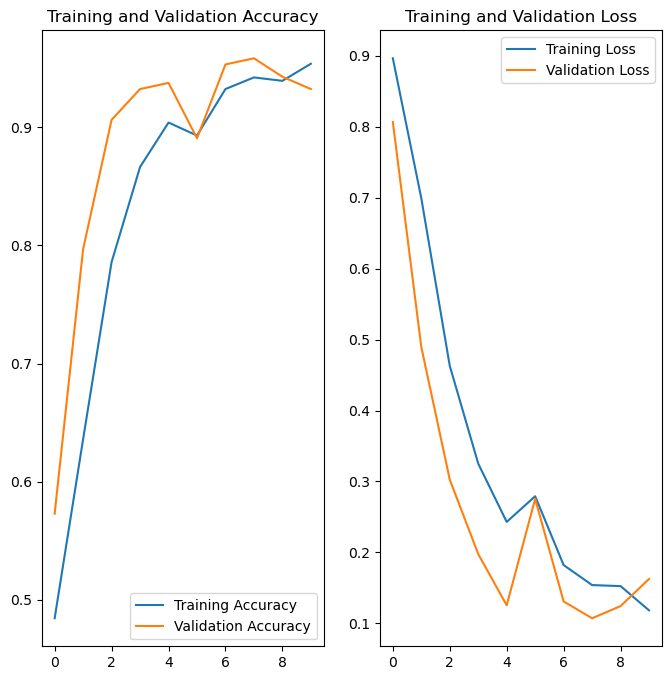

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Making Predictions on a Test Batch
- **Operation**: Makes a prediction on the first image of a test batch.
- **Visualization**: Displays the first image from the batch.
- **Label Comparison**: Prints the actual label from `class_names` and the predicted label from the model.
- **Prediction**: Uses `model.predict()` to predict the labels for the entire batch and prints the predicted label for the first image.


First image to predict
Actual lable:  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
Predicted lable:  Potato___Early_blight


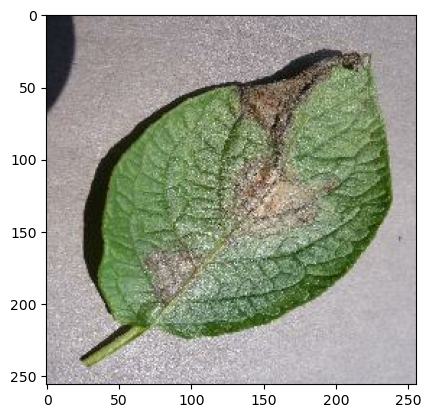

In [38]:
import numpy as np 
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


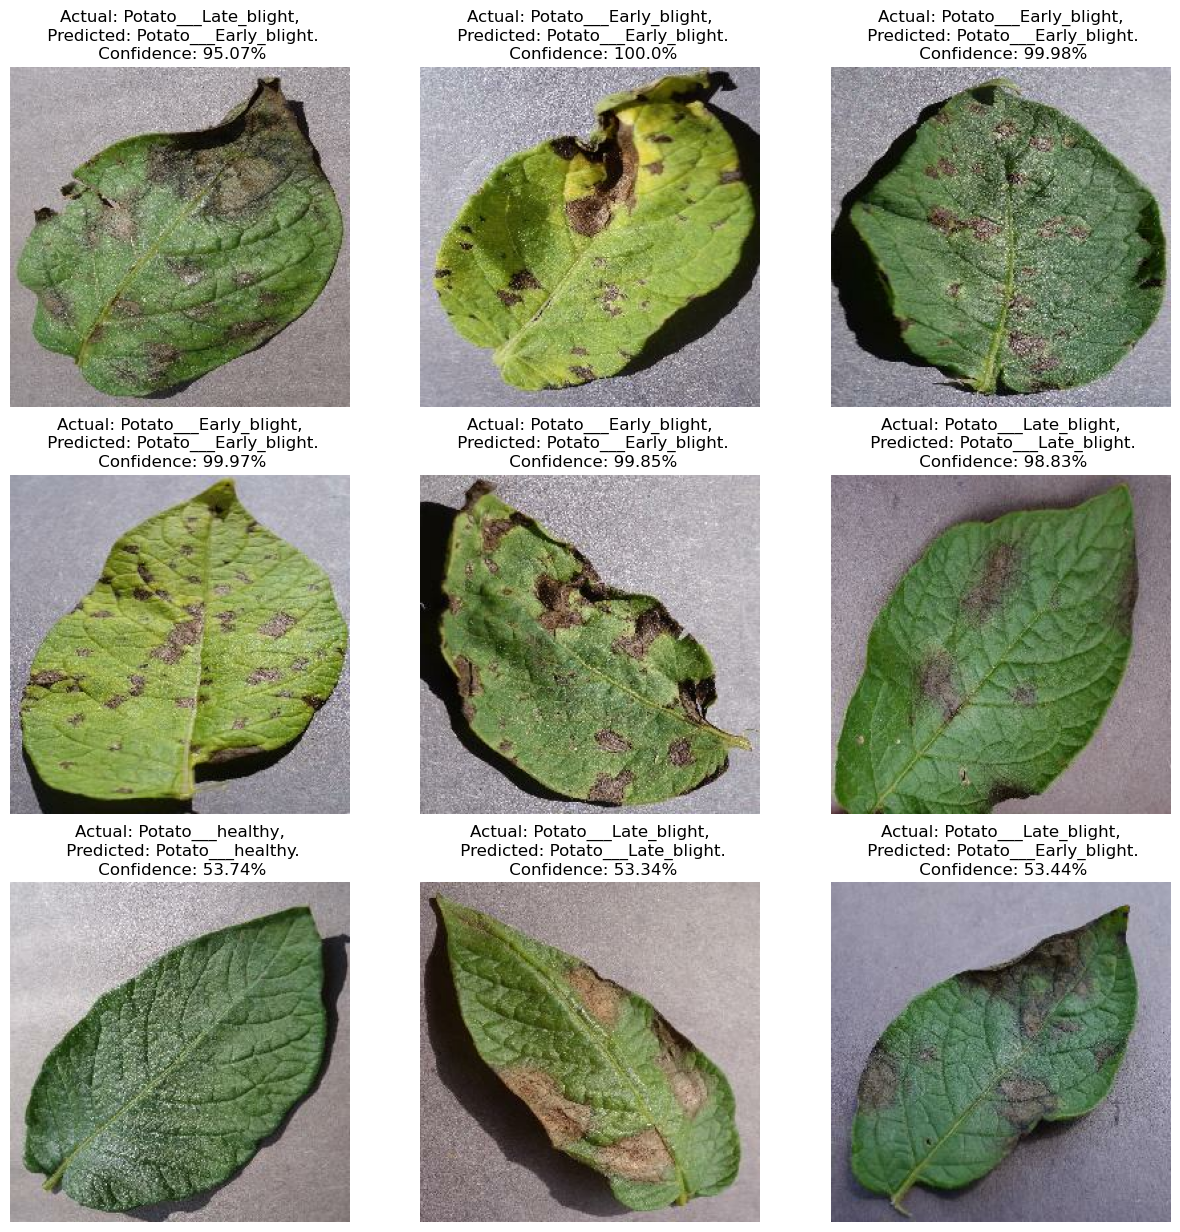

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
import os
models_dir = os.path.join(os.getcwd(), "models")


if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_version = max([int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]) + 1

model_path = os.path.join(models_dir, f"{model_version}.keras")
model.save(model_path)
print(f"Model saved to {model_path}")


Model saved to c:\Code\potato-disease\training\models\1.keras
